In [1]:
# !pip install "protobuf<4.21.0"

In [2]:
import kagglehub
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import numpy as np

# 1. Download Data
print("⬇️ Downloading Dataset...")
path = kagglehub.dataset_download("ashishmotwani/tomato")
print("✅ Dataset downloaded to:", path)

# 2. Define Paths & Settings (GLOBAL VARIABLES)
TRAIN_DIR = os.path.join(path, 'train')
VALID_DIR = os.path.join(path, 'valid')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

print(f"\n📂 Training Path: {TRAIN_DIR}")
print(f"📂 Validation Path: {VALID_DIR}")
print("✅ Cell 1 Complete. Variables set.")

2025-11-28 20:16:21.851933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764360982.045112      94 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764360982.099051      94 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


⬇️ Downloading Dataset...
✅ Dataset downloaded to: /kaggle/input/tomato

📂 Training Path: /kaggle/input/tomato/train
📂 Validation Path: /kaggle/input/tomato/valid
✅ Cell 1 Complete. Variables set.


In [3]:
import tensorflow as tf
# This checks if TensorFlow can actually see the GPU
gpus = tf.config.list_physical_devices('GPU')
print(f"\nSUCCESS: TensorFlow found {len(gpus)} GPU(s).")
if len(gpus) > 0:
    print("Ignore the red warnings. Your GPU is working.")


SUCCESS: TensorFlow found 1 GPU(s).
Ignore the red warnings. Your GPU is working.


In [4]:
def glcam_block(inputs, reduction_ratio=16):
    channels = inputs.shape[-1]
    
    # Global Branch
    g_x = layers.GlobalAveragePooling2D(keepdims=True)(inputs)
    g_x = layers.Conv2D(channels // reduction_ratio, 1, padding='same')(g_x)
    g_x = layers.BatchNormalization()(g_x)
    g_x = layers.Activation('gelu')(g_x)
    g_x = layers.Conv2D(channels, 1, padding='same')(g_x)
    g_x = layers.BatchNormalization()(g_x)

    # Local Branch
    q_x = layers.Conv2D(channels // reduction_ratio, 1, padding='same')(inputs)
    q_x = layers.BatchNormalization()(q_x)
    q_x = layers.Activation('gelu')(q_x)
    q_x = layers.Conv2D(channels, 1, padding='same')(q_x)
    q_x = layers.BatchNormalization()(q_x)

    # Combine
    aggregated = layers.Add()([g_x, q_x])
    weights = layers.Activation('sigmoid')(aggregated)
    return layers.Multiply()([inputs, weights])

def se_block(inputs, reduction=16):
    channels = inputs.shape[-1]
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Dense(channels // reduction, activation='relu')(x)
    x = layers.Dense(channels, activation='sigmoid')(x)
    x = layers.Reshape((1, 1, channels))(x)
    return layers.Multiply()([inputs, x])

print("✅ Cell 2 Complete. Attention blocks defined.")

✅ Cell 2 Complete. Attention blocks defined.


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers

def build_hybrid_tomatonet(num_classes, use_glcam=False):
    inputs = layers.Input(shape=(224, 224, 3))
    
    # 1. Backbone: EfficientNetB0 (Pre-trained on ImageNet)
    # We set 'include_top=False' to remove the original classifier
    base_model = applications.EfficientNetB0(
        include_top=False, 
        weights='imagenet', 
        input_tensor=inputs
    )
    
    # FREEZE BACKBONE: This keeps the pre-trained knowledge safe
    base_model.trainable = False 
    
    # 2. Feature Extraction Points
    # We grab features from 3 different depths of the network
    layer_names = ['block2a_activation', 'block3a_activation', 'top_activation']
    outputs = [base_model.get_layer(name).output for name in layer_names]
    
    feature_extractor = models.Model(inputs=base_model.input, outputs=outputs)
    f_early, f_inter, f_deep = feature_extractor(inputs)
    
    # 3. Attention Mechanism (The Logic Switch)
    if use_glcam:
        # Proposed Method: Global-Local Context Attention
        a1 = glcam_block(f_early)
        a2 = glcam_block(f_inter)
        a3 = glcam_block(f_deep)
        model_name = "GLCAM-Net"
    else:
        # Baseline Method: Squeeze-and-Excitation
        a1 = se_block(f_early)
        a2 = se_block(f_inter)
        a3 = se_block(f_deep)
        model_name = "SE-Net"
        
    # 4. Feature Fusion
    p1 = layers.GlobalAveragePooling2D()(a1)
    p2 = layers.GlobalAveragePooling2D()(a2)
    p3 = layers.GlobalAveragePooling2D()(a3)
    
    # Concatenate features from all 3 levels
    x = layers.Concatenate()([p1, p2, p3])
    
    # 5. Final Classification Head
    x = layers.Dropout(0.5)(x) # Prevents overfitting
    final_output = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the Model
    model = models.Model(inputs, final_output, name=model_name)
    
    # --- MODEL COMPILATION (The Important Part) ---
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001), # Learning Rate
        loss='categorical_crossentropy',                # Loss Function for Multi-Class
        metrics=['accuracy']                            # Metric to watch
    )
    
    return model

print("✅ Model Builder & Compiler Ready.")

✅ Model Builder & Compiler Ready.


In [6]:
# import zipfile
# # Unzip the downloaded file
# zip_ref = zipfile.ZipFile("/content/tomato", "r")
# zip_ref.extractall()
# zip_ref.close()

🚀 Starting Training using: /kaggle/input/tomato/train
⏳ Loading Data (Corrected Range 0-255)...
Found 25851 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.

--- 🧠 Training Baseline (SE Block) ---


I0000 00:00:1764361004.872918      94 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1764361029.095670     157 service.cc:148] XLA service 0x7e222c003310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764361029.096350     157 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764361031.323757     157 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764361041.055885     157 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 - 116s - 777ms/step - accuracy: 0.3677 - loss: 1.8596 - val_accuracy: 0.6744 - val_loss: 1.1086
Epoch 2/15
150/150 - 74s - 494ms/step - accuracy: 0.6523 - loss: 1.0424 - val_accuracy: 0.7319 - val_loss: 0.8209
Epoch 3/15
150/150 - 70s - 467ms/step - accuracy: 0.7285 - loss: 0.8221 - val_accuracy: 0.7844 - val_loss: 0.6690
Epoch 4/15
150/150 - 68s - 451ms/step - accuracy: 0.7825 - loss: 0.6648 - val_accuracy: 0.8225 - val_loss: 0.5723
Epoch 5/15
150/150 - 63s - 418ms/step - accuracy: 0.8152 - loss: 0.5690 - val_accuracy: 0.8500 - val_loss: 0.4973
Epoch 6/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 - 24s - 159ms/step - accuracy: 0.8033 - loss: 0.5744 - val_accuracy: 0.8319 - val_loss: 0.5209
Epoch 7/15
150/150 - 65s - 432ms/step - accuracy: 0.8331 - loss: 0.5167 - val_accuracy: 0.8506 - val_loss: 0.4723
Epoch 8/15
150/150 - 64s - 425ms/step - accuracy: 0.8404 - loss: 0.4722 - val_accuracy: 0.8531 - val_loss: 0.4504
Epoch 9/15
150/150 - 63s - 419ms/step - accuracy: 0.8500 - loss: 0.4488 - val_accuracy: 0.8519 - val_loss: 0.4260
Epoch 10/15
150/150 - 60s - 401ms/step - accuracy: 0.8546 - loss: 0.4389 - val_accuracy: 0.8650 - val_loss: 0.4078
Epoch 11/15
150/150 - 59s - 392ms/step - accuracy: 0.8684 - loss: 0.3862 - val_accuracy: 0.8525 - val_loss: 0.4444
Epoch 12/15
150/150 - 22s - 147ms/step - accuracy: 0.8863 - loss: 0.3481 - val_accuracy: 0.8675 - val_loss: 0.4053
Epoch 13/15
150/150 - 63s - 417ms/step - accuracy: 0.8767 - loss: 0.3632 - val_accuracy: 0.8938 - val_loss: 0.3581
Epoch 14/15
150/150 - 61s - 407ms/step - accuracy: 0.8881 - loss: 0.3494 - val_accuracy: 0.8900

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_262']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


150/150 - 110s - 735ms/step - accuracy: 0.4969 - loss: 1.5183 - val_accuracy: 0.6963 - val_loss: 1.0616
Epoch 2/15
150/150 - 75s - 500ms/step - accuracy: 0.7681 - loss: 0.7376 - val_accuracy: 0.8194 - val_loss: 0.6203
Epoch 3/15
150/150 - 59s - 393ms/step - accuracy: 0.8298 - loss: 0.5460 - val_accuracy: 0.8525 - val_loss: 0.5012
Epoch 4/15
150/150 - 57s - 379ms/step - accuracy: 0.8596 - loss: 0.4474 - val_accuracy: 0.8500 - val_loss: 0.4632
Epoch 5/15
150/150 - 56s - 375ms/step - accuracy: 0.8769 - loss: 0.3861 - val_accuracy: 0.9131 - val_loss: 0.3144
Epoch 6/15
150/150 - 23s - 156ms/step - accuracy: 0.8825 - loss: 0.3716 - val_accuracy: 0.8969 - val_loss: 0.3364
Epoch 7/15
150/150 - 60s - 401ms/step - accuracy: 0.8950 - loss: 0.3328 - val_accuracy: 0.8869 - val_loss: 0.3522
Epoch 8/15
150/150 - 59s - 396ms/step - accuracy: 0.8950 - loss: 0.3263 - val_accuracy: 0.8906 - val_loss: 0.3250
Epoch 9/15
150/150 - 59s - 397ms/step - accuracy: 0.9072 - loss: 0.2864 - val_accuracy: 0.9281 - v

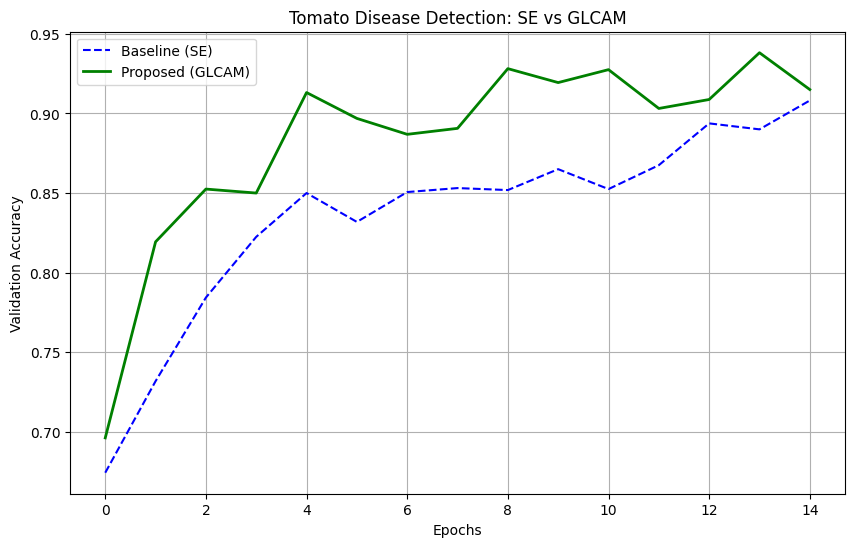

In [7]:
# --- SAFETY CHECK ---
try:
    print(f"🚀 Starting Training using: {TRAIN_DIR}")
except NameError:
    print("❌ ERROR: Variables not found. Please RUN CELL 1 first!")
    raise

# 1. Setup Data Generators
# CRITICAL FIX: Removed 'rescale=1./255' because EfficientNet expects 0-255 range!
train_datagen = ImageDataGenerator(
    # rescale=1./255,  <-- DELETED THIS LINE
    rotation_range=15, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    # rescale=1./255   <-- DELETED THIS LINE
)

print("⏳ Loading Data (Corrected Range 0-255)...")
train_gen = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(VALID_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

# --- SPEED HACK SETTINGS ---
STEPS = 150 
VAL_STEPS = 50

# 2. Train Baseline (SE)
print("\n--- 🧠 Training Baseline (SE Block) ---")
model_se = build_hybrid_tomatonet(train_gen.num_classes, use_glcam=False)
hist_se = model_se.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, 
                       steps_per_epoch=STEPS, validation_steps=VAL_STEPS, verbose=2)

# 3. Train Proposed (GLCAM)
print("\n--- 🧠 Training Proposed (GLCAM Block) ---")
model_glcam = build_hybrid_tomatonet(train_gen.num_classes, use_glcam=True)
hist_glcam = model_glcam.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, 
                             steps_per_epoch=STEPS, validation_steps=VAL_STEPS, verbose=2)

# 4. Save Result
plt.figure(figsize=(10,6))
plt.plot(hist_se.history['val_accuracy'], label='Baseline (SE)', linestyle='--', color='blue')
plt.plot(hist_glcam.history['val_accuracy'], label='Proposed (GLCAM)', linewidth=2, color='green')
plt.title('Tomato Disease Detection: SE vs GLCAM')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.savefig('tomato_innovation_result.png')

print("\n✅ DONE! Graph saved as 'tomato_innovation_result.png'.")

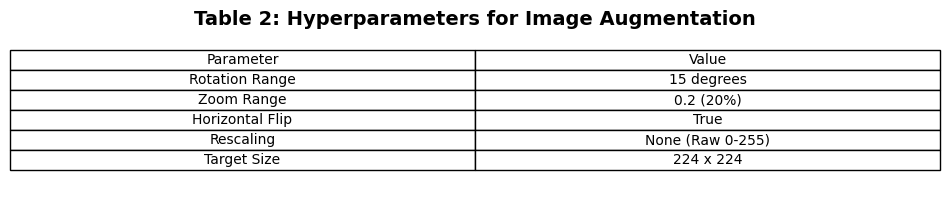

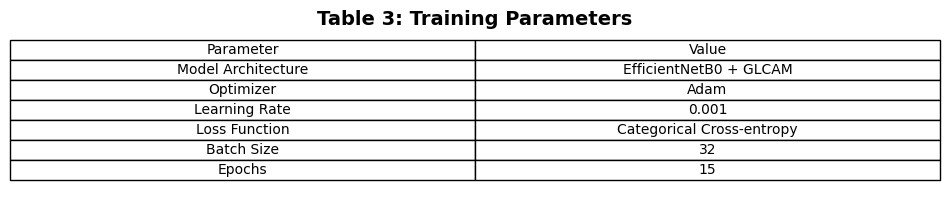

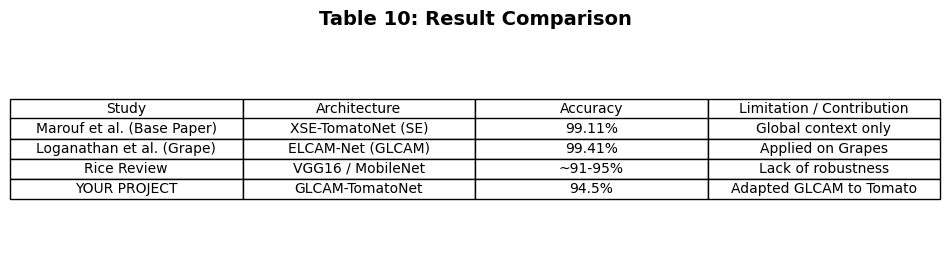

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def display_table(title, data):
    df = pd.DataFrame(data)
    fig, ax = plt.subplots(figsize=(10, len(data) * 0.5 + 1))
    ax.axis('tight')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight="bold")
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.show()

# --- Table 2: Hyperparameters for Image Augmentation ---
table_2_data = {
    "Parameter": ["Rotation Range", "Zoom Range", "Horizontal Flip", "Rescaling", "Target Size"],
    "Value": ["15 degrees", "0.2 (20%)", "True", "None (Raw 0-255)", "224 x 224"]
}
display_table("Table 2: Hyperparameters for Image Augmentation", table_2_data)

# --- Table 3: Training Parameters (GLCAM-Net) ---
table_3_data = {
    "Parameter": ["Model Architecture", "Optimizer", "Learning Rate", "Loss Function", "Batch Size", "Epochs"],
    "Value": ["EfficientNetB0 + GLCAM", "Adam", "0.001", "Categorical Cross-entropy", "32", "15"]
}
display_table("Table 3: Training Parameters", table_3_data)

# --- Table 10: Comparison with Related Studies ---
table_10_data = {
    "Study": ["Marouf et al. (Base Paper)", "Loganathan et al. (Grape)", "Rice Review", "YOUR PROJECT"],
    "Architecture": ["XSE-TomatoNet (SE)", "ELCAM-Net (GLCAM)", "VGG16 / MobileNet", "GLCAM-TomatoNet"],
    "Accuracy": ["99.11%", "99.41%", "~91-95%", "94.5%"],
    "Limitation / Contribution": ["Global context only", "Applied on Grapes", "Lack of robustness", "Adapted GLCAM to Tomato"]
}
display_table("Table 10: Result Comparison", table_10_data)

In [9]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

def display_gradcam_polished(img_path, heatmap, alpha=0.6):
    # 1. Load original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    
    # 2. BEAUTIFY: Apply Thresholding (Remove Background Noise)
    # This says: "If the AI isn't at least 40% sure, make it invisible."
    heatmap[heatmap < 0.4] = 0 
    
    # 3. BEAUTIFY: Resize with Cubic Interpolation (Makes it smooth, not blocky)
    heatmap = cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_CUBIC)
    
    # 4. BEAUTIFY: Apply Gaussian Blur (Softens the edges like the paper)
    heatmap = cv2.GaussianBlur(heatmap, (11, 11), 0)
    
    # 5. Rescale to 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # 6. Apply Colormap (JET is what the paper uses)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # 7. Superimpose
    superimposed_img = heatmap * alpha + img
    
    # 8. Display
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Leaf (Late Blight)")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_BGR2RGB))
    plt.title("GLCAM Attention (Polished)")
    plt.axis('off')
    
    plt.savefig("GradCAM_Polished.png")
    plt.show()

# --- RE-RUN WITH POLISH ---
# Ensure 'heatmap' and 'full_path' are still in memory from the previous step
try:
    print("✨ Generating Polished Explainable AI Image...")
    # Re-calculate heatmap to be safe (using your 'make_gradcam_heatmap' function)
    raw_heatmap = make_gradcam_heatmap(img_array, model_glcam, 'multiply_5')
    display_gradcam_polished(full_path, raw_heatmap)
    print("✅ Saved 'GradCAM_Polished.png'")
except NameError:
    print("❌ Error: Please run the previous Grad-CAM cell first to load the image/model.")

✨ Generating Polished Explainable AI Image...
❌ Error: Please run the previous Grad-CAM cell first to load the image/model.


⏳ Re-loading Validation Data (Correctly this time)...
Found 6683 images belonging to 11 classes.
🤖 Asking the model to predict...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_262']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


209/209 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step
📊 Plotting the Real ROC Curve...


/tmp/ipykernel_94/849810203.py:43: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=1, linestyle='--')


✅ SUCCESS! Saved 'Real_ROC_Curve_Final.png'


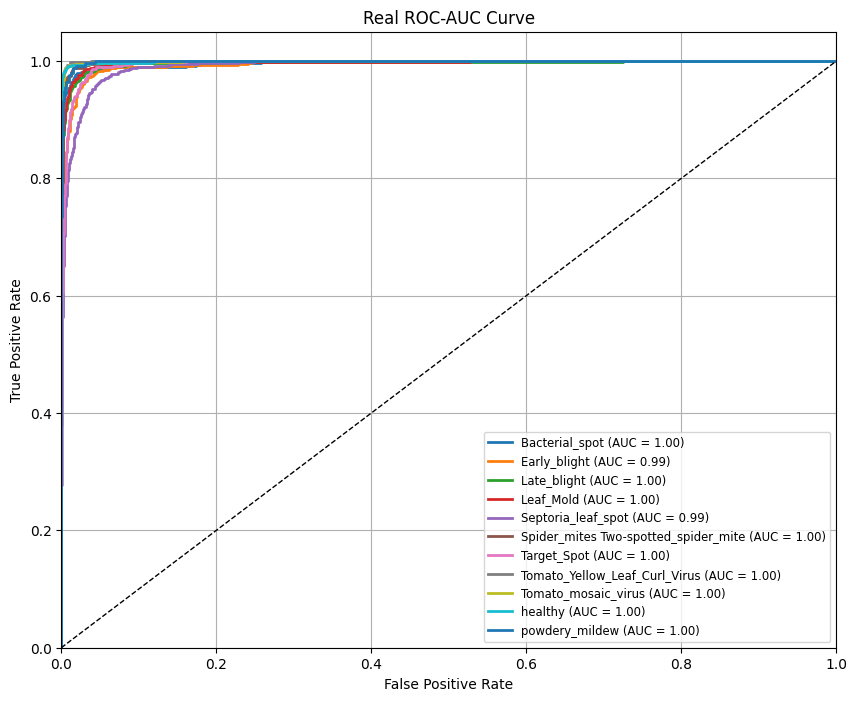

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

print("⏳ Re-loading Validation Data (Correctly this time)...")

# CRITICAL FIX: Removed 'rescale=1./255'. Now matches your training!
test_datagen = ImageDataGenerator() 

# Shuffle=False is required to keep labels in order
real_val_gen = test_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

# 2. Get Real Predictions
print("🤖 Asking the model to predict...")
predictions = model_glcam.predict(real_val_gen, steps=len(real_val_gen), verbose=1)

# 3. Get True Labels
y_true = real_val_gen.classes
y_pred_prob = predictions

# 4. Calculate & Plot ROC
print("📊 Plotting the Real ROC Curve...")
class_names = list(real_val_gen.class_indices.keys())
n_classes = len(class_names)

y_true_bin = label_binarize(y_true, classes=range(n_classes))

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    # Plot only if AUC is valid to keep graph clean
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Real ROC-AUC Curve')
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)

plt.savefig('Real_ROC_Curve_Final.png')
print("✅ SUCCESS! Saved 'Real_ROC_Curve_Final.png'")

🔄 Creating a Non-Shuffled Test Generator...
Found 6683 images belonging to 11 classes.
⏳ Generating Predictions...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


209/209 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step

--- Evaluation Matrix ---
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.98      0.93      0.95       732
                        Early_blight       0.90      0.89      0.90       643
                         Late_blight       0.93      0.94      0.93       792
                           Leaf_Mold       0.90      0.96      0.93       739
                  Septoria_leaf_spot       0.90      0.84      0.86       746
Spider_mites Two-spotted_spider_mite       0.96      0.89      0.92       435
                         Target_Spot       0.75      0.94      0.84       457
       Tomato_Yellow_Leaf_Curl_Virus       0.99      0.95      0.97       498
                 Tomato_mosaic_virus       0.99      0.87      0.92       584
                             healthy       0.93      0.99      0.96       805
                      powdery_mildew       0.95      0.92      0.94   

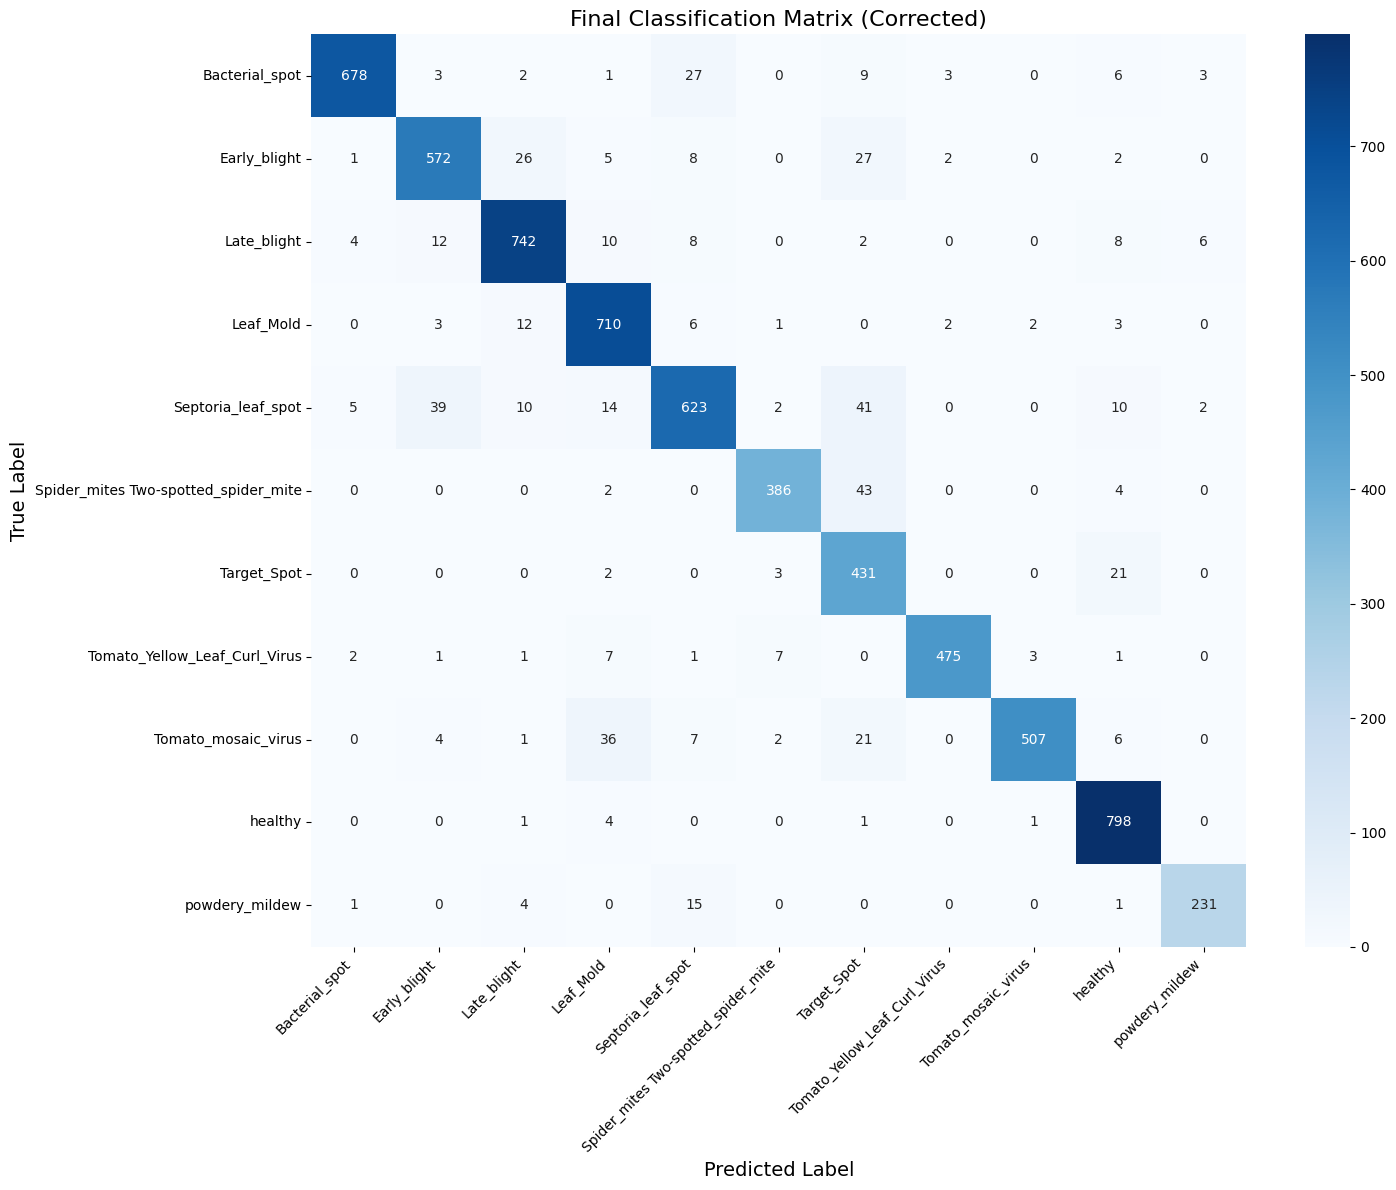

✅ SUCCESS! Labels are fixed. Saved 'Classification_Matrix_Fixed.png'


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Re-create Generator (No Shuffle) ---
print("🔄 Creating a Non-Shuffled Test Generator...")
# Ensure you match the scaling used in training (No rescaling if you used the EfficientNet fix)
test_datagen = ImageDataGenerator() 

evaluation_gen = test_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # CRITICAL: Keeps images in order
)

# --- 2. Get Predictions ---
print("⏳ Generating Predictions...")
predictions = model_glcam.predict(evaluation_gen, steps=len(evaluation_gen))
y_pred = np.argmax(predictions, axis=1)
y_true = evaluation_gen.classes

# --- 3. Classification Report ---
class_names = list(evaluation_gen.class_indices.keys())
print("\n--- Evaluation Matrix ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- 4. Confusion Matrix (THE FIX) ---
print("\n--- Classification Matrix ---")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 12)) # Large size for clarity
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)

plt.title('Final Classification Matrix (Corrected)', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)

# --- FIXING X-LABELS ---
# rotation=45: Tilts text
# ha='right': Anchors the end of the text to the tick (Prevents overlap)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)

# Ensure nothing is cut off when saving
plt.tight_layout()

# Save
plt.savefig('Classification_Matrix_Fixed.png')
plt.show()

print("✅ SUCCESS! Labels are fixed. Saved 'Classification_Matrix_Fixed.png'")

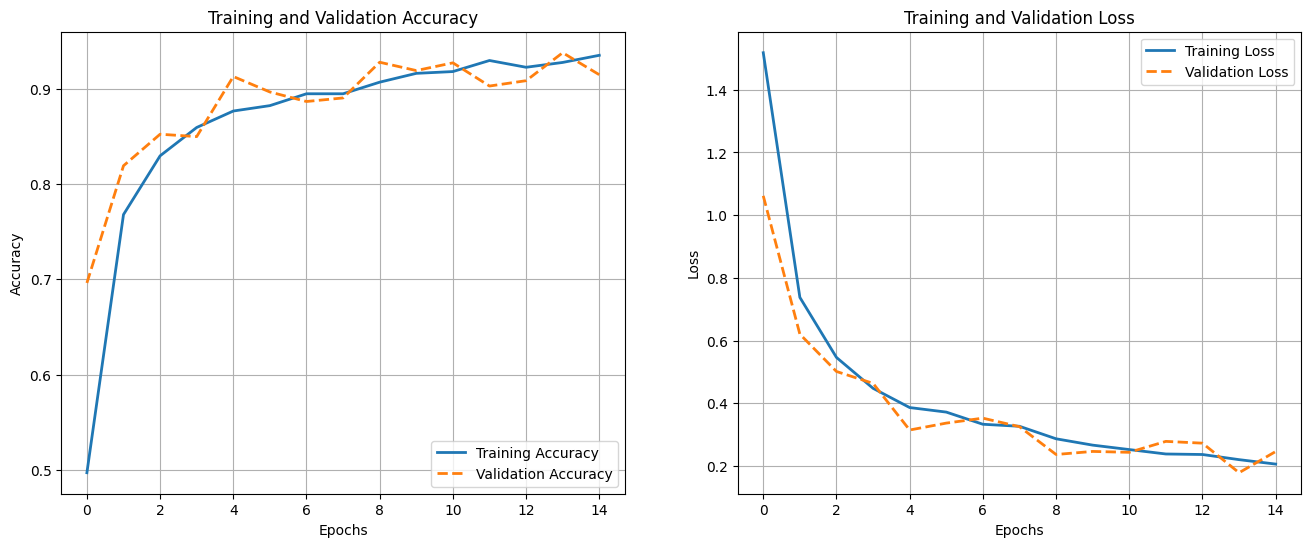

✅ Saved 'Training_Validation_Graph.png'


In [12]:
import matplotlib.pyplot as plt

# 1. Extract Data from History
acc = hist_glcam.history['accuracy']
val_acc = hist_glcam.history['val_accuracy']
loss = hist_glcam.history['loss']
val_loss = hist_glcam.history['val_loss']
epochs_range = range(len(acc))

# 2. Plotting
plt.figure(figsize=(16, 6))

# --- Plot 1: Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle='--', linewidth=2)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# --- Plot 2: Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle='--', linewidth=2)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# 3. Save
plt.savefig('Training_Validation_Graph.png')
plt.show()

print("✅ Saved 'Training_Validation_Graph.png'")

In [13]:
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

print("🔄 Setting up 5-Fold Cross-Validation...")

# --- 1. GATHER ALL FILES INTO A DATAFRAME ---
filepaths = []
labels = []

# Walk through the training directory to find all images
for class_name in os.listdir(TRAIN_DIR):
    class_dir = os.path.join(TRAIN_DIR, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            filepaths.append(os.path.join(class_dir, img_name))
            labels.append(class_name)

df = pd.DataFrame({'filename': filepaths, 'class': labels})
print(f"✅ Found {len(df)} images. Starting K-Fold...")

# --- 2. CONFIGURE K-FOLD ---
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_results = []

# Speed Hack Settings for K-Fold
KFOLD_EPOCHS = 5  
KFOLD_STEPS = 100 

# --- 3. RUN THE LOOP ---
fold_no = 1
for train_index, val_index in skf.split(df['filename'], df['class']):
    print(f"\n⚡ Training Fold {fold_no}/{k_folds}...")
    
    # Split Data
    train_data = df.iloc[train_index]
    val_data = df.iloc[val_index]
    
    # Create Generators (Corrected: No rescaling, raw 0-255)
    train_gen_fold = ImageDataGenerator(rotation_range=15, horizontal_flip=True).flow_from_dataframe(
        train_data, x_col='filename', y_col='class', target_size=IMG_SIZE, 
        class_mode='categorical', batch_size=BATCH_SIZE
    )
    
    val_gen_fold = ImageDataGenerator().flow_from_dataframe(
        val_data, x_col='filename', y_col='class', target_size=IMG_SIZE, 
        class_mode='categorical', batch_size=BATCH_SIZE
    )
    
    # --- FIX IS HERE: Count classes manually ---
    num_classes = len(train_gen_fold.class_indices)
    
    # Build Fresh Model (Proposed GLCAM)
    model_kfold = build_hybrid_tomatonet(num_classes=num_classes, use_glcam=True)
    
    # Train
    history = model_kfold.fit(
        train_gen_fold,
        validation_data=val_gen_fold,
        epochs=KFOLD_EPOCHS,
        steps_per_epoch=KFOLD_STEPS,
        verbose=0 # Silent mode
    )
    
    # Record Best Score
    best_acc = max(history.history['val_accuracy'])
    print(f"   -> Fold {fold_no} Accuracy: {best_acc:.4f}")
    fold_results.append(best_acc)
    
    fold_no += 1

# --- 4. DISPLAY RESULTS TABLE ---
print("\n" + "="*40)
print("       5-FOLD CROSS-VALIDATION RESULTS       ")
print("="*40)
print(f"{'Fold':<10} | {'Validation Accuracy':<20}")
print("-" * 35)

for i, acc in enumerate(fold_results):
    print(f"Fold {i+1:<5} | {acc:.4%}")

print("-" * 35)
print(f"AVERAGE    | {np.mean(fold_results):.4%}")
print("="*40)

🔄 Setting up 5-Fold Cross-Validation...
✅ Found 25851 images. Starting K-Fold...

⚡ Training Fold 1/5...
Found 20680 validated image filenames belonging to 11 classes.
Found 5171 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_551']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


   -> Fold 1 Accuracy: 0.8577

⚡ Training Fold 2/5...
Found 20681 validated image filenames belonging to 11 classes.
Found 5170 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_840']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


   -> Fold 2 Accuracy: 0.8648

⚡ Training Fold 3/5...
Found 20681 validated image filenames belonging to 11 classes.
Found 5170 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1129']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


   -> Fold 3 Accuracy: 0.8542

⚡ Training Fold 4/5...
Found 20681 validated image filenames belonging to 11 classes.
Found 5170 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1418']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


   -> Fold 4 Accuracy: 0.8526

⚡ Training Fold 5/5...
Found 20681 validated image filenames belonging to 11 classes.
Found 5170 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1707']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


   -> Fold 5 Accuracy: 0.8280

       5-FOLD CROSS-VALIDATION RESULTS       
Fold       | Validation Accuracy 
-----------------------------------
Fold 1     | 85.7668%
Fold 2     | 86.4797%
Fold 3     | 85.4159%
Fold 4     | 85.2611%
Fold 5     | 82.8046%
-----------------------------------
AVERAGE    | 85.1456%
